## nSBM for random network

In this notebook we show how nSBM performs when random data are presented. In particular, we analyze PBMC data (preprocessed by scanpy) and randomize the kNN graph.

In [1]:
import scanpy as sc
import schist as scs
import scipy.sparse
import warnings
import powerlaw
import scipy.stats
import graph_tool.all as gt
warnings.filterwarnings("ignore")
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.settings.verbosity = 2
sc.set_figure_params(dpi_save=300)

In [3]:
adata = sc.datasets.pbmc3k_processed()
rdata = adata.copy()

In [4]:
adata.uns['neighbors']['params']['method'] = 'umap'
adata.uns['neighbors']['params']['n_neighbos'] = n_neighbors


OverloadedDict, wrapping:
	{'params': {'method': 'umap', 'n_neighbors': array([10])}}
With overloaded keys:
	['connectivities', 'distances'].

In [5]:
adata.uns['neighbors']['connectivities'] = 

<2638x2638 sparse matrix of type '<class 'numpy.float64'>'
	with 42406 stored elements in Compressed Sparse Row format>

In [4]:
scs.inference.leiden(adata)
scs.inference.nested_model(adata)

running Leiden clustering
    finished (0:00:34)
minimizing the nested Stochastic Block Model
    done (0:09:22)
    finished (0:09:23)


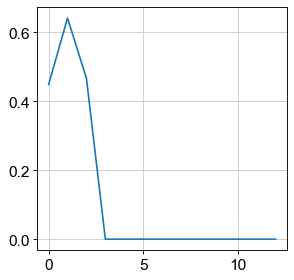

In [5]:
plot(adata.uns['schist']['stats']['modularity'])

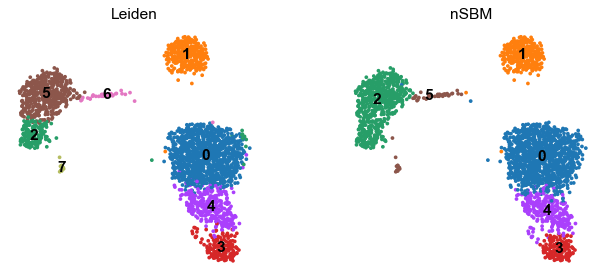

In [6]:
sc.pl.umap(adata, color=['leiden', 'nsbm_level_1'], legend_loc='on data', 
           frameon=False,  title=['Leiden', 'nSBM'], save='Original_PBMC3k.png')

In [7]:
import sklearn.metrics
sklearn.metrics.adjusted_rand_score(adata.obs.leiden, adata.obs.nsbm_level_1)

0.8699142596243707

Here we extract the connectivities, which will be randomized

In [9]:
# extract kNN graph
conn = adata.obsp['connectivities'].todense()
dist = adata.obsp['distances'].todense()

# extract the edgelist

idx = np.nonzero(np.triu(conn,1))
weights = conn[idx].A1
dists = dist[idx].A1
e0 = idx[0].copy()
e1 = idx[1].copy()
#oe0 = idx[0].copy()
#oe1 = idx[1].copy()

# randomize the edgelist
np.random.shuffle(e1)
np.random.shuffle(e0)

# build a random kNN graph. In this way we conserve node degree
r_conn = np.zeros_like(conn)
r_dist = np.zeros_like(dist)

for x in range(len(e0)):
#    on0 = oe0[x]
#    on1 = oe1[x]
    n0 = e0[x]
    n1 = e1[x]
    r_conn[n0, n1] = weights[x]
    r_conn[n1, n0] = weights[x]
    r_dist[n0, n1] = dists[x]
    r_dist[n1, n0] = dists[x]


# plug the new data into an AnnData
rdata.obsp['connectivities'] = scipy.sparse.csr_matrix(r_conn)
rdata.obsp['distances'] = scipy.sparse.csr_matrix(r_dist)

# just some checks here
og = scs._utils.get_graph_tool_from_adjacency(adata.obsp['connectivities'], directed=False)
rg = scs._utils.get_graph_tool_from_adjacency(rdata.obsp['connectivities'], directed=False)

#print(og.num_vertices(), rg.num_vertices())

#print(og.num_edges(), rg.num_edges())

Check that the original kNN and the random have similar degree distribution. We do this using a Kolmogorov-Smirnoff test on the degree

In [10]:
on, od = gt.vertex_hist(og, 'total')
rn, rd = gt.vertex_hist(rg, 'total')
ks = scipy.stats.ks_2samp(rn, on)
print(f'D: {ks[0]}, p: {ks[1]}')

D: 0.0733032873806999, p: 0.7028526992719394


Also, fit and plot the degree distribution

In [11]:
of = powerlaw.Fit(on)
rf = powerlaw.Fit(rn)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [12]:
of.alpha, rf.alpha

(1.6640656709526693, 1.704133395286875)

<AxesSubplot:>

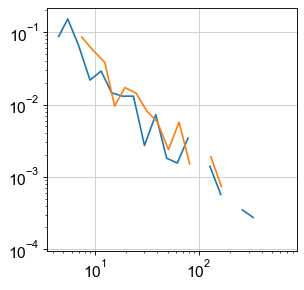

In [13]:
of.plot_pdf()# original_data=True)
rf.plot_pdf()# original_data=True)

Now we extract cell groups with default method (leiden, to optimize modularity) and nSBM

In [14]:
scs.inference.leiden(rdata)
scs.inference.nested_model(rdata)

running Leiden clustering
    finished (0:02:01)
minimizing the nested Stochastic Block Model
    done (0:02:46)
    finished (0:02:46)


Plot results on the precomputed UMAP

In [15]:
print(f'Leiden results in {len(rdata.obs["leiden"].cat.categories)} group(s)')
print(f'nSBM results in {len(rdata.obs["nsbm_level_0"].cat.categories)} group(s)')
                           

Leiden results in 24 group(s)
nSBM results in 1 group(s)


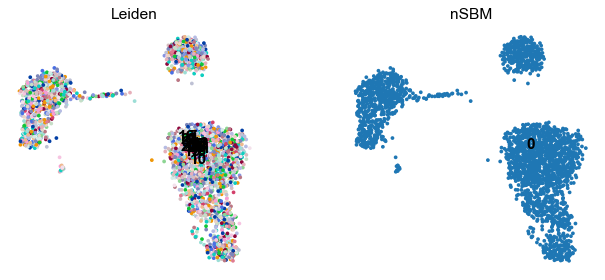

In [16]:
sc.pl.umap(rdata, color=['leiden', 'nsbm_level_0'], legend_loc='on data', 
           frameon=False, title=['Leiden', 'nSBM'], save='Random_PBMC3K.png')


Also, calculate a new UMAP and plot results on that. Note that UMAP embedding looks like a blob, reflecting the absence of information

computing UMAP
    finished (0:01:10)


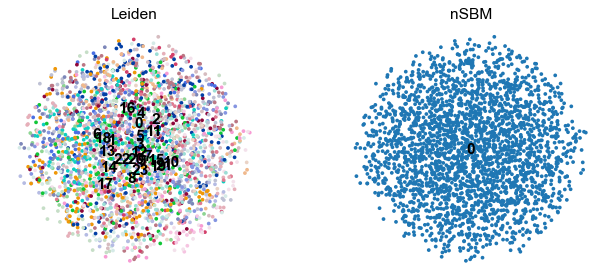

In [17]:
sc.tl.umap(rdata)
sc.pl.umap(rdata, color=['leiden', 'nsbm_level_0'], legend_loc='on data', 
           frameon=False, title=['Leiden', 'nSBM'], save='Random_PBMC3K_blob.png')



In [18]:
print(np.sum(adata.uns['schist']['stats']['level_entropy']), np.sum(rdata.uns['schist']['stats']['level_entropy']))

97385.67716421829 121129.56143641614


In [19]:
scs.io.write(adata, "PBMC_3k_074")
scs.io.write(rdata, "PBMC_3k_random_074")

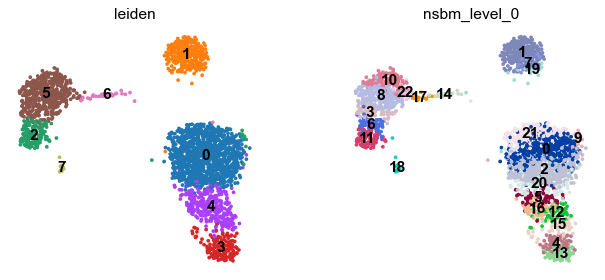

In [20]:
sc.pl.umap(adata, color=['leiden', 'nsbm_level_0'], legend_loc='on data',
          frameon=False)